In [1]:
# Get some image/annotation pairs for example 
filename_pairs = [
('./VOC2007/JPEGImages/000032.jpg', './VOC2007/SegmentationClass/000032.png'),
('./VOC2007/JPEGImages/000033.jpg', './VOC2007/SegmentationClass/000033.png'),
('./VOC2007/JPEGImages/000039.jpg', './VOC2007/SegmentationClass/000039.png')
                 ]

In [2]:
%matplotlib inline

# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
#import skimage.io as io
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
tfrecords_filename = 'pascal_voc_segmentation.tfrecord'

In [5]:
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

In [9]:
# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

In [10]:
for img_path, annotation_path in filename_pairs:
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

In [140]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

In [141]:
i=0
for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))
    print(i)
    i=i+1

0
1
2


In [145]:
example.features.feature

{'mask_raw': bytes_list {
  value: "\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000

In [142]:
height

375

In [143]:
width

500

In [144]:
375*500*3

562500

In [127]:
img_1d = np.fromstring(img_string, dtype=np.uint8)

In [128]:
img_1d.shape

(562500,)

In [129]:
reconstructed_img = img_1d.reshape((height, width, -1))

In [131]:
reconstructed_img.shape

(375, 500, 3)

In [88]:
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))

True
True
True
True
True
True


---

In [54]:
from PIL import Image
import io

In [55]:
tfrecords_filename = 'voc_2007_test_000.tfrecord'

In [56]:
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

In [81]:
i=0
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['image/height']
                                 .int64_list
                                 .value[0])
    width = int(example.features.feature['image/width']
                                    .int64_list
                                    .value[0])
    img_string = (example.features.feature['image/encoded']
                                      .bytes_list
                                      .value[0])
    
    #img_1d = np.fromstring(img_string, dtype=np.uint8)
    #reconstructed_img = img_1d.reshape((height, width, -1))
    
    print(height, '  ', width)
    i=i+1
    #break

375    500
406    500
375    500
375    500
480    354
324    500
375    500
333    500
375    500
285    380
332    500
375    500
500    486
500    375
331    500
335    500
375    500
375    500
332    500
500    333
375    500
356    500
375    500
375    500
333    500
334    500
375    500
375    500
500    375
333    500
272    500
375    500
375    500
375    500
375    500
375    500
500    332
375    500
357    500
375    500
333    500
375    500
330    500
333    500
500    333
375    500
333    500
375    500
333    500
500    330
375    500
270    360
256    432
375    500
333    500
333    500
375    500
375    500
375    500
500    375
500    375
375    500
375    500
215    500
375    500
367    500
375    500
375    500
500    333
334    500
333    500
346    500
360    500
375    500
500    375
333    500
500    360
266    400
375    500
375    500
374    500
480    318
375    500
332    500
480    319
375    500
500    375
375    500
375    500
375    500
500    449

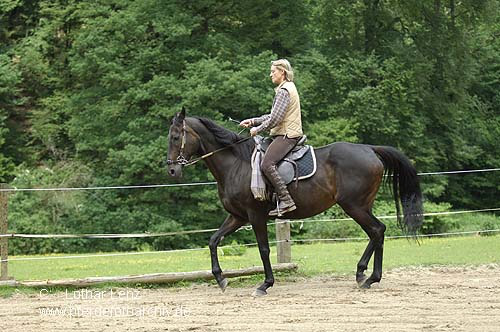

In [82]:
image = Image.open(io.BytesIO(img_string))
image

In [83]:
len(image.tobytes())

498000

In [84]:
a = image.tobytes()

In [85]:
len(a)

498000

In [86]:
img_1d = np.fromstring(a, dtype=np.uint8)

In [87]:
reconstructed_img = img_1d.reshape((height, width, -1))

In [88]:
reconstructed_img.shape

(332, 500, 3)

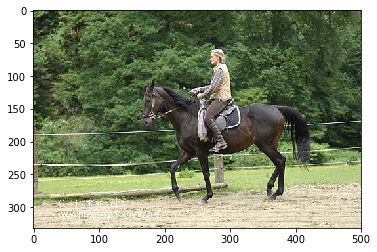

In [89]:
plt.imshow(reconstructed_img)

In [105]:
example.features.feature

{'image/object/bbox/xmin': float_list {
  value: 0.5260000228881836
  value: 0.33000001311302185
  value: 0.009999999776482582
  value: 0.4819999933242798
  value: 0.5540000200271606
}
, 'image/object/bbox/ymax': float_list {
  value: 0.9039999842643738
  value: 0.9919999837875366
  value: 0.9973333477973938
  value: 0.7973333597183228
  value: 0.5866666436195374
}
, 'image/height': int64_list {
  value: 375
}
, 'image/width': int64_list {
  value: 500
}
, 'image/shape': int64_list {
  value: 375
  value: 500
  value: 3
}
, 'image/object/bbox/truncated': int64_list {
  value: 0
  value: 0
  value: 0
  value: 0
  value: 0
}
, 'image/object/bbox/label': int64_list {
  value: 9
  value: 9
  value: 9
  value: 9
  value: 9
}
, 'image/encoded': bytes_list {
  value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\00

In [106]:
len(example.features.feature)

14

In [15]:
height = int(example.features.feature['image/height']
                                 .int64_list
                                 .value[0])
width = int(example.features.feature['image/width']
                                .int64_list
                                .value[0])
img_string = (example.features.feature['image/encoded']
                                  .bytes_list
                                  .value[0])
print(height)
print(width)

500
353


In [16]:
len(img_string)

78771

In [17]:
353*500

176500

In [136]:
img_1d = np.fromstring(img_string, dtype=np.uint8)

In [18]:
image_data = tf.gfile.FastGFile('./VOC2007/JPEGImages/000032.jpg', 'r').read()

In [38]:
len(image_data)

54757

In [39]:
type(image_data)

bytes

In [30]:
500*281*3

421500

In [47]:
image = Image.open(io.BytesIO(image_data))

In [53]:
type(image)

PIL.JpegImagePlugin.JpegImageFile